In [ ]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from tensorflow import keras
from keras import layers
from keras.models import Sequential

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d uraninjo/augmented-alzheimer-mri-dataset

 97% 368M/380M [00:01<00:00, 239MB/s]
100% 380M/380M [00:01<00:00, 250MB/s]


In [ ]:
import zipfile

zip_ref = zipfile.ZipFile('/content/augmented-alzheimer-mri-dataset.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
#Parameters

img_height = 200
img_width = 190

In [ ]:
validation_split = 0.2
batch_size = 32

train_ds = keras.utils.image_dataset_from_directory(
    directory='/content/AugmentedAlzheimerDataset',
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    validation_split=validation_split,
    subset='training',
    seed = 123
)

val_ds = keras.utils.image_dataset_from_directory(
    directory='/content/AugmentedAlzheimerDataset',
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    validation_split=validation_split,
    subset='validation',
    seed = 123
)

Found 33984 files belonging to 4 classes.
Using 27188 files for training.
Found 33984 files belonging to 4 classes.
Using 6796 files for validation.


In [ ]:
def residual_block(x, filters, strides=1, kernel_size=3, activation='relu'):
    y = layers.Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    y = layers.BatchNormalization()(y)
    y = layers.Activation(activation)(y)

    y = layers.Conv2D(filters, kernel_size=kernel_size, padding='same')(y)
    y = layers.BatchNormalization()(y)

    if strides > 1:
        x = layers.Conv2D(filters, kernel_size=1, strides=strides, padding='same')(x)

    out = layers.Add()([x, y])
    out = layers.Activation(activation)(out)
    return out

def Model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)

    x = residual_block(x, filters=128, strides=2)
    x = residual_block(x, filters=128)

    x = residual_block(x, filters=256, strides=2)
    x = residual_block(x, filters=256)

    x = residual_block(x, filters=512, strides=2)
    x = residual_block(x, filters=512)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

input_shape = (200,190,3)
num_classes = 4
model = Model(input_shape, num_classes)

In [ ]:
#Compiling the model

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
#Summary

model.summary()

In [ ]:
hist = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 10
)

Epoch 1/10
850/850 [==============================] - 104s 104ms/step - loss: 0.8548 - accuracy: 0.6064 - val_loss: 1.4115 - val_accuracy: 0.4854
Epoch 2/10
850/850 [==============================] - 87s 102ms/step - loss: 0.5270 - accuracy: 0.7719 - val_loss: 0.7234 - val_accuracy: 0.7237
Epoch 3/10
850/850 [==============================] - 87s 102ms/step - loss: 0.3186 - accuracy: 0.8701 - val_loss: 0.9049 - val_accuracy: 0.7579
Epoch 4/10
850/850 [==============================] - 88s 103ms/step - loss: 0.2000 - accuracy: 0.9225 - val_loss: 0.5387 - val_accuracy: 0.8271
Epoch 5/10
850/850 [==============================] - 93s 109ms/step - loss: 0.1334 - accuracy: 0.9484 - val_loss: 0.4633 - val_accuracy: 0.8733
Epoch 6/10
850/850 [==============================] - 87s 102ms/step - loss: 0.0942 - accuracy: 0.9649 - val_loss: 0.5625 - val_accuracy: 0.8455
Epoch 7/10
850/850 [==============================] - 89s 104ms/step - loss: 0.0753 - accuracy: 0.9718 - val_loss: 0.2957 - val_a

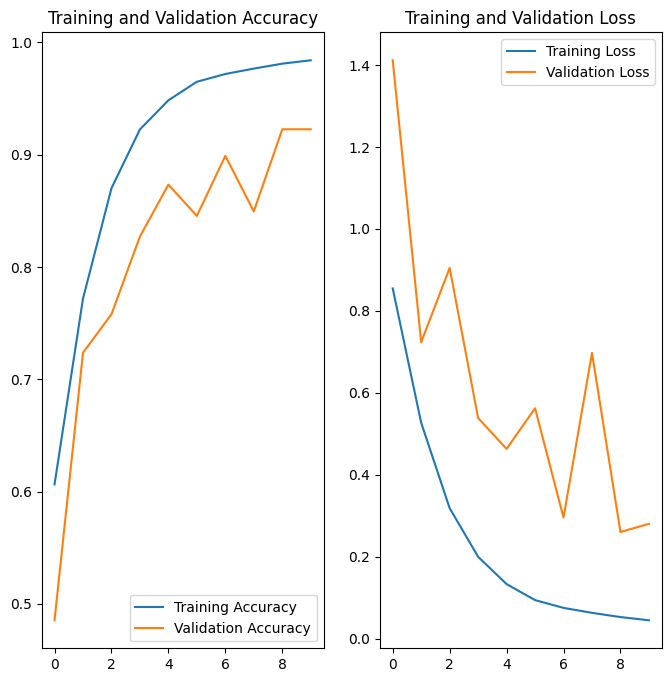

In [ ]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.save('adam-resnet18.keras')